____________________
# Exploring MEI with Beautiful Soup

### Notebook for Music 255:  Encoding Music
### Haverford College (Haverford, PA USA)

### by Richard Freedman (Haverford College), Daniel Russo-Batterham (Melbourne University), and Oleh Shostak (Haverford College)

In this assignment, you will get an opportunity to engage, explore, and experiment with **XML** files through Python and **Beautiful Soup**. As mentioned in class, **XML** stands for **eXtensible Markup Language** and mainly serves to transport and store data. At its core, XML was designed to be **both machine- and human-readable**. In the case of music files, the common encoding standard is **MEI**, which stands for **Music Encoding Initiative** and is built on top of the XML framework.


Mainly, this assignment focuses on:

* **access**: downloading, storing, reading, processing XML files
* **analysis**: performing basic quantitative and qualitative analysis of XML files
* **interpretation**: exploring the meaning and utility of XML files from both analytical and creative perspectives 

As we deal with these files, we will make use of Beautiful Soup – a Python library that makes interacting with XML and HTML friendly and comfortable. Or at least tries to... You can access Beautiful Soup's documentation [here](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Read the [Music 255 Beautiful Soup and MEI Tutorial for ideas on different ways to work with your files](https://github.com/RichardFreedman/Encoding_Music/blob/main/01_Tutorials/06_Beautiful_Soup_MEI.md).

XML files are guided by **markup rules**, which you can read more about [here](https://www.w3schools.com/xml/xml_syntax.asp) and consist of **elements**, which you can dive into [here](https://www.w3schools.com/xml/xml_elements.asp).

MEI files are primarily XML files with music-specific sections, elements, and structure. You can learn more about MEI [here](https://music-encoding.org/).


----

## Setup: Importing Python Libraries

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import os
import bs4
from bs4 import BeautifulSoup

from pathlib import Path
import requests
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import math
import numpy as np

# Visualisation dependencies
import textwrap
import networkx as nx
from pyvis.network import Network
import seaborn as sns

In [2]:
# this will show you all of the Beautiful Soup methods:
[m for m in dir(BeautifulSoup) if m[0].islower()]

['append',
 'childGenerator',
 'children',
 'clear',
 'decode',
 'decode_contents',
 'decompose',
 'decomposed',
 'default',
 'descendants',
 'encode',
 'encode_contents',
 'endData',
 'extend',
 'extract',
 'fetchNextSiblings',
 'fetchParents',
 'fetchPrevious',
 'fetchPreviousSiblings',
 'find',
 'findAll',
 'findAllNext',
 'findAllPrevious',
 'findChild',
 'findChildren',
 'findNext',
 'findNextSibling',
 'findNextSiblings',
 'findParent',
 'findParents',
 'findPrevious',
 'findPreviousSibling',
 'findPreviousSiblings',
 'find_all',
 'find_all_next',
 'find_all_previous',
 'find_next',
 'find_next_sibling',
 'find_next_siblings',
 'find_parent',
 'find_parents',
 'find_previous',
 'find_previous_sibling',
 'find_previous_siblings',
 'format_string',
 'formatter_for_name',
 'get',
 'getText',
 'get_attribute_list',
 'get_text',
 'handle_data',
 'handle_endtag',
 'handle_starttag',
 'has_attr',
 'has_key',
 'index',
 'insert',
 'insert_after',
 'insert_before',
 'isSelfClosing',
 'is_

## Import MEI File

As your first and perhaps most important step, you'll have to go find some data. For this homework assignment, we will work with selected files from the [CRIM Project](https://crimproject.org/models/). Once you've picked your file and copied its URL, use the function provided below to **import the 'raw' XML**:

In [3]:
# function to extract xml document from given url
def getXML(url):
    # request for xml document of given url
    response = requests.get(url)    
    # response will be provided as raw text
    return response.text

In the cell below, **read in your file** and store it in the "xml_document" variable:

In [4]:
xml_document = getXML('https://crimproject.org/mei/CRIM_Model_0019.mei')

Once you've imported a file, you should be able to **convert it into a Beautiful Soup Object**:

In [5]:
soup = BeautifulSoup(xml_document, 'xml')

Here you can scroll through the entire MEI file. Note the the `soup` object has a `prettify` method that makes the XML easier to read by indenting nested elements:

In [6]:
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<?xml-model href="https://music-encoding.org/schema/4.0.1/mei-CMN.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?>
<?xml-model href="https://music-encoding.org/schema/4.0.1/mei-CMN.rng" type="application/xml" schematypens="http://purl.oclc.org/dsdl/schematron"?>
<mei meiversion="4.0.1" xml:id="m-1" xmlns="http://www.music-encoding.org/ns/mei">
 <meiHead xml:id="m-2">
  <fileDesc xml:id="m-3">
   <titleStmt>
    <title>
     Veni sponsa Christi
    </title>
    <respStmt>
     <persName auth="VIAF" auth.uri="http://viaf.org/viaf/92280854" role="composer">
      Giovanni Pierluigi da Palestrina
     </persName>
     <persName role="editor">
      Marco Gurrieri
     </persName>
     <persName role="editor">
      Vincent Besson
     </persName>
     <persName role="editor">
      Richard Freedman
     </persName>
    </respStmt>
   </titleStmt>
   <pubStmt>
    <publisher>
     Citations: The Renaissance Imitation Mas

# Visualising XML as network graphs

Before digging into the details of the XML and starting to navigate these `soup` objects programmatically, let's visualize several XML snippets to get a high-level overview of how it is structured. 

First we will create several functions that we will use in the subsequent visualisations. Eventually you may choose to explore these functions and tweak their behavior, but for now we will use them as is:

In [7]:
def format_element(tag: bs4.element.Tag, wrap_length=20, exclude=[]):
    attrs_list = []
    
    for a, v in tag.attrs.items():
        if a in exclude:
            continue
        attrs_list.append(f"{a}={v}")
    
    formatted_string = f"{tag.name} ({' '.join(attrs_list)})" if attrs_list else tag.name
    
    return textwrap.fill(formatted_string, wrap_length)



def create_network(tag: bs4.element.Tag, with_attributes: bool = False, attrs_to_exclude=[]):

    all_tags = [tag] + tag.find_all()

    G = nx.DiGraph()

    for node in all_tags:
        depth = len(list(node.parents))
        G.add_node(
                   id(node), 
                   label=format_element(node, exclude=attrs_to_exclude) if with_attributes else node.name,
                   value=len(list(node.descendants)),
                   group=depth,
                   level=depth,
                   scaling={'label': {'enabled': True}},
                  )

    for node in all_tags:
        for child in node.children:
            if child.name:
                G.add_edge(id(node), id(child), 
                           arrows='to',
                       id=f"{id(node)}_{node.name}|{id(child)}_{child.name}")

    return G



def display_network(network, 
                    filename="tmp.html", 
                    width=900, 
                    height=900, 
                    bgcolor="white",
                    font_color="black",
                    notebook=True,
                   ):

    nt = Network(notebook=notebook, width=width, height=height, bgcolor=bgcolor, font_color=font_color)
    nt.from_nx(network)

    return nt.show(filename)

Let's start by creating a network of a single measure, in this case **measure 66**, which includes a **supplied accidental**:

In [8]:
measure_network = create_network(soup.find("measure", {"n": 66}))
display_network(measure_network, filename="simple_measure.html")

Already from this we can see that a `measure` element contains `staff` elements and so on.

Let's do the same thing again, but this time showing some **attributes**. We will hide the `xml:id` attributes since they are quite verbose:

In [9]:
measure_network_with_attrs = create_network(
    soup.find("measure", {"n": 66}), 
    with_attributes=True, 
    attrs_to_exclude=["xml:id"]
)
display_network(measure_network_with_attrs, filename="measure_with_attrs.html")

Last, let's create a **network of the entire piece**. We won't display it here because it risks slowing down our browser. Instead, we can save it to an HTML file and open that file separately:

In [10]:
model_0019_network = create_network(soup)
display_network(model_0019_network, notebook=False, filename="CRIM_Model_0019.html")

If you open that file in a browser you should see something like this!

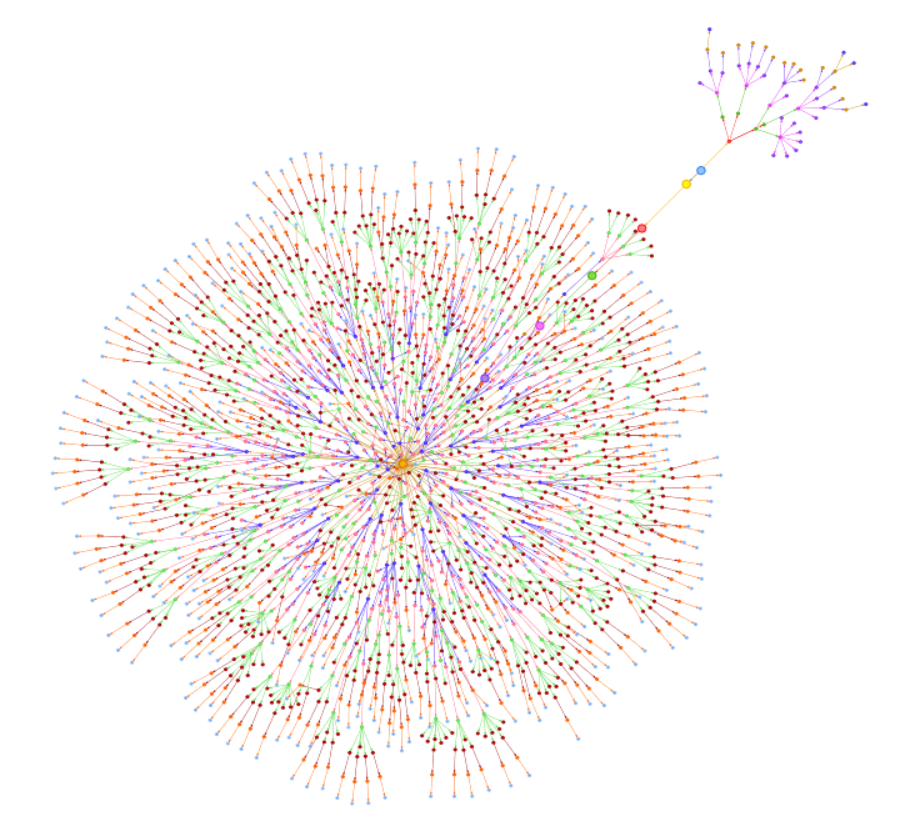

It is this big, tree-like structure that we will be learning how to move around and analyze through the rest of this notebook using some of the methods provided by BeautifulSoup.

## Key Methods

### `find()` and `find_all()`

- `soup.find('Your_Element_Name')` will return just the _first_ matching element
- `soup.find_all('Your_Element_Name')` will return a list of _all_ the matching elements

### Methods can be strung together:
Sometimes it is difficult to navigate directly to the element or elements of interest. One way around this is to chain these finding methods together. This is somewhat analogous to climbing from one branch to another of a real tree. Here are a couple of examples of chaining these methods.

- `soup.find('Your_Element_Name').findParent()` will find the _parent tag_ of the first matching element
- `soup.find('Your_Element_Name').findChild()` will find the _child tag_ of the first matching element

### Match Elements and Attributes with Dictionaries

- `soup.find_all('Your_Element_Name', {'Your_Attribute_Name' : 'Your_Attribute_Value)` will return only those elements that match both the given type and attribute

### The Whole Family

Parents and children are only two possible of many relationships among elements.  See the diagram below to understand _ancestors_, _siblings_, and _descendents_.  

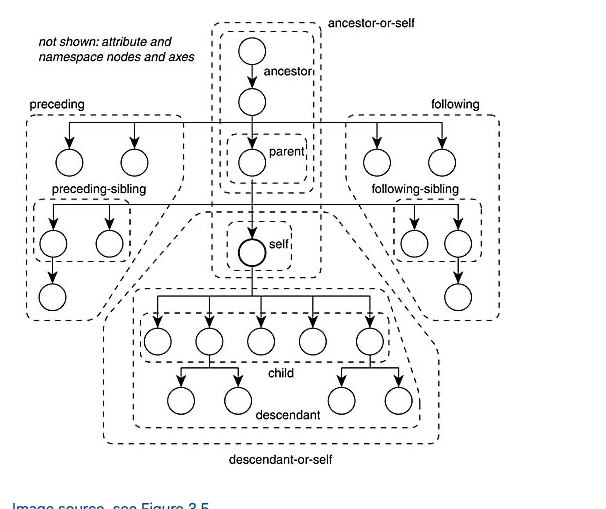

Diagram from [Stack Overflow](https://stackoverflow.com/questions/49966055/difference-between-child-following-and-descendant-in-xpath-axes)


## Find Staves

In [11]:
# All the Staves as a List
soup.find_all("staffDef")

[<staffDef clef.line="2" clef.shape="G" key.sig="0" label="Cantus" lines="5" n="1" xml:id="m-30">
 <label>Cantus</label>
 <instrDef midi.channel="1" midi.pan="26" midi.volume="100" xml:id="m-32"/>
 </staffDef>,
 <staffDef clef.line="2" clef.shape="G" key.sig="0" label="Altus" lines="5" n="2" xml:id="m-33">
 <label>Altus</label>
 <instrDef midi.channel="1" midi.pan="46" midi.volume="100" xml:id="m-35"/>
 </staffDef>,
 <staffDef clef.dis="8" clef.dis.place="below" clef.line="2" clef.shape="G" key.sig="0" label="Tenor" lines="5" n="3" xml:id="m-36">
 <label>Tenor</label>
 <instrDef midi.channel="1" midi.pan="81" midi.volume="100" xml:id="m-38"/>
 </staffDef>,
 <staffDef clef.line="4" clef.shape="F" key.sig="0" label="Bassus" lines="5" n="4" xml:id="m-39">
 <label>Bassus</label>
 <instrDef midi.channel="1" midi.pan="101" midi.volume="100" xml:id="m-41"/>
 </staffDef>]

In [12]:
# Find just the First Staff 
print(soup.find_all("staffDef")[0].prettify())


<staffDef clef.line="2" clef.shape="G" key.sig="0" label="Cantus" lines="5" n="1" xml:id="m-30">
 <label>
  Cantus
 </label>
 <instrDef midi.channel="1" midi.pan="26" midi.volume="100" xml:id="m-32"/>
</staffDef>



In [13]:
# Staves with a certain clef shape
for g_clef in soup.find_all("staffDef", {'clef.shape' : 'G'}):
    print(g_clef.prettify())

<staffDef clef.line="2" clef.shape="G" key.sig="0" label="Cantus" lines="5" n="1" xml:id="m-30">
 <label>
  Cantus
 </label>
 <instrDef midi.channel="1" midi.pan="26" midi.volume="100" xml:id="m-32"/>
</staffDef>

<staffDef clef.line="2" clef.shape="G" key.sig="0" label="Altus" lines="5" n="2" xml:id="m-33">
 <label>
  Altus
 </label>
 <instrDef midi.channel="1" midi.pan="46" midi.volume="100" xml:id="m-35"/>
</staffDef>

<staffDef clef.dis="8" clef.dis.place="below" clef.line="2" clef.shape="G" key.sig="0" label="Tenor" lines="5" n="3" xml:id="m-36">
 <label>
  Tenor
 </label>
 <instrDef midi.channel="1" midi.pan="81" midi.volume="100" xml:id="m-38"/>
</staffDef>



## Find Measures


In [14]:
# all the measures
soup.find_all("measure")

[<measure label="1" n="1" xml:id="m-61">
 <staff n="1" xml:id="m-62">
 <layer n="1" xml:id="m-63">
 <note dur="breve" dur.ppq="2048" oct="5" pname="d" pnum="74" stem.dir="down" xml:id="m-64">
 <verse n="1" xml:id="m-79">
 <syl con="d" wordpos="i" xml:id="m-80">
             Ve
            </syl>
 </verse>
 </note>
 </layer>
 </staff>
 <staff n="2" xml:id="m-65">
 <layer n="1" xml:id="m-66">
 <mRest dur="breve" xml:id="m-67"/>
 </layer>
 </staff>
 <staff n="3" xml:id="m-68">
 <layer n="1" xml:id="m-69">
 <mRest dur="breve" xml:id="m-70"/>
 </layer>
 </staff>
 <staff n="4" xml:id="m-71">
 <layer n="1" xml:id="m-72">
 <mRest dur="breve" xml:id="m-73"/>
 </layer>
 </staff>
 </measure>,
 <measure n="2" xml:id="m-74">
 <staff n="1" xml:id="m-75">
 <layer n="1" xml:id="m-76">
 <note dur="1" dur.ppq="1024" oct="4" pname="b" pnum="71" stem.dir="down" xml:id="m-77">
 <verse n="1" xml:id="m-81">
 <syl wordpos="t" xml:id="m-82">
             ni
            </syl>
 </verse>
 </note>
 <note dur="1" 

In [15]:
# find the LAST measure
print(soup.find_all("measure")[-1].prettify())

<measure n="67" right="end" xml:id="m-2203">
 <staff n="1" xml:id="m-2204">
  <layer n="1" xml:id="m-2205">
   <note dur="long" dur.ppq="4096" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-2206">
    <verse n="1" xml:id="m-2211">
     <syl wordpos="t" xml:id="m-2212">
      num.
     </syl>
    </verse>
   </note>
  </layer>
 </staff>
 <staff n="2" xml:id="m-2213">
  <layer n="1" xml:id="m-2214">
   <note dur="long" dur.ppq="4096" oct="4" pname="d" pnum="62" stem.dir="up" xml:id="m-2215">
    <verse n="1" xml:id="m-2220">
     <syl wordpos="t" xml:id="m-2221">
      num.
     </syl>
    </verse>
   </note>
  </layer>
 </staff>
 <staff n="3" xml:id="m-2222">
  <layer n="1" xml:id="m-2223">
   <note dur="long" dur.ppq="4096" oct="3" pname="g" pnum="43" stem.dir="up" xml:id="m-2224">
    <verse n="1" xml:id="m-2229">
     <syl wordpos="t" xml:id="m-2230">
      num.
     </syl>
    </verse>
   </note>
  </layer>
 </staff>
 <staff n="4" xml:id="m-2231">
  <layer n="1" xml:id="m-2232"

In [16]:
# find the first staff of the last measure:
print(soup.find_all("measure")[-1].find("staff").prettify())

<staff n="1" xml:id="m-2204">
 <layer n="1" xml:id="m-2205">
  <note dur="long" dur.ppq="4096" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-2206">
   <verse n="1" xml:id="m-2211">
    <syl wordpos="t" xml:id="m-2212">
     num.
    </syl>
   </verse>
  </note>
 </layer>
</staff>



In [17]:
# measure 66, which has our editorial accidental
measure_66 = soup.find('measure', {'n' : '66'})
print(measure_66.prettify())

<measure n="66" xml:id="m-2182">
 <staff n="1" xml:id="m-2183">
  <layer n="1" xml:id="m-2184">
   <note dur="4" dur.ppq="256" oct="4" pname="a" pnum="69" stem.dir="up" xml:id="m-2185"/>
   <note dur="4" dur.ppq="256" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-2186"/>
   <note dur="1" dur.ppq="1024" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-2187"/>
   <note dur="2" dur.ppq="512" oct="4" pname="f" pnum="66" stem.dir="up" xml:id="m-2188">
    <supplied reason="edit" xml:id="m-469e72a0-f1e2-4792-8290-bafbac06fb3f">
     <accid accid="s" func="edit" place="above" xml:id="m-2189"/>
    </supplied>
   </note>
  </layer>
 </staff>
 <staff n="2" xml:id="m-2190">
  <layer n="1" xml:id="m-2191">
   <note dur="1" dur.ppq="1024" oct="4" pname="e" pnum="64" stem.dir="up" xml:id="m-2192">
    <verse n="1" xml:id="m-2216">
     <syl con="d" wordpos="i" xml:id="m-2217">
      ae
     </syl>
    </verse>
   </note>
   <note dur="1" dur.ppq="1024" oct="4" pname="d" pnum="62" stem.dir=

## Find Notes

In [18]:
# all the notes returned as a list
soup.find_all("note")

[<note dur="breve" dur.ppq="2048" oct="5" pname="d" pnum="74" stem.dir="down" xml:id="m-64">
 <verse n="1" xml:id="m-79">
 <syl con="d" wordpos="i" xml:id="m-80">
             Ve
            </syl>
 </verse>
 </note>,
 <note dur="1" dur.ppq="1024" oct="4" pname="b" pnum="71" stem.dir="down" xml:id="m-77">
 <verse n="1" xml:id="m-81">
 <syl wordpos="t" xml:id="m-82">
             ni
            </syl>
 </verse>
 </note>,
 <note dur="1" dur.ppq="1024" oct="5" pname="d" pnum="74" stem.dir="down" xml:id="m-78">
 <verse n="1" xml:id="m-98">
 <syl con="d" wordpos="i" xml:id="m-99">
             spon
            </syl>
 </verse>
 </note>,
 <note dur="breve" dur.ppq="2048" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-85">
 <verse n="1" xml:id="m-106">
 <syl con="d" wordpos="i" xml:id="m-107">
             Ve
            </syl>
 </verse>
 </note>,
 <note dur="1" dur.ppq="1024" oct="5" pname="e" pnum="76" stem.dir="down" xml:id="m-95">
 <verse n="1" xml:id="m-100">
 <syl wordpos="t" xml:i

In [19]:
# last note of the piece (via the list of notes)
soup.find_all("note")[-1]

<note dur="long" dur.ppq="4096" oct="3" pname="g" pnum="55" stem.dir="down" xml:id="m-2233">
<verse n="1" xml:id="m-2238">
<syl wordpos="t" xml:id="m-2239">
            num.
           </syl>
</verse>
</note>

In [20]:
# the LAST note of the FIRST staff
print(soup.find_all("measure")[-1].find("staff").find_all("note")[-1].prettify())

<note dur="long" dur.ppq="4096" oct="4" pname="g" pnum="67" stem.dir="up" xml:id="m-2206">
 <verse n="1" xml:id="m-2211">
  <syl wordpos="t" xml:id="m-2212">
   num.
  </syl>
 </verse>
</note>



In [21]:
# the pitch of that note:
# find the note
last_note_staff_one = soup.find_all("measure")[-1].find("staff").find_all("note")[-1]
# get the value of an attribute
last_note_staff_one.get('pname')

'g'

## Counting Notes (and Some Charts and Graphs)

In [22]:
pitches = [n.get('pname') for n in soup.find_all('note')]
counted = Counter(pitches)
total_n = len(soup.find_all('note'))

counted_notes = pd.Series(counted).to_frame('count').sort_index()
counted_notes['scaled'] = counted_notes['count'] / total_n
counted_notes.rename(columns={"count": "Count", "scaled": "Scaled_Count"}, inplace=True)
counted_notes


Count  Scaled_Count
a    108      0.153627
b     86      0.122333
c    110      0.156472
d    107      0.152205
e     88      0.125178
f     79      0.112376
g    125      0.177809

### A Bar Chart of Notes

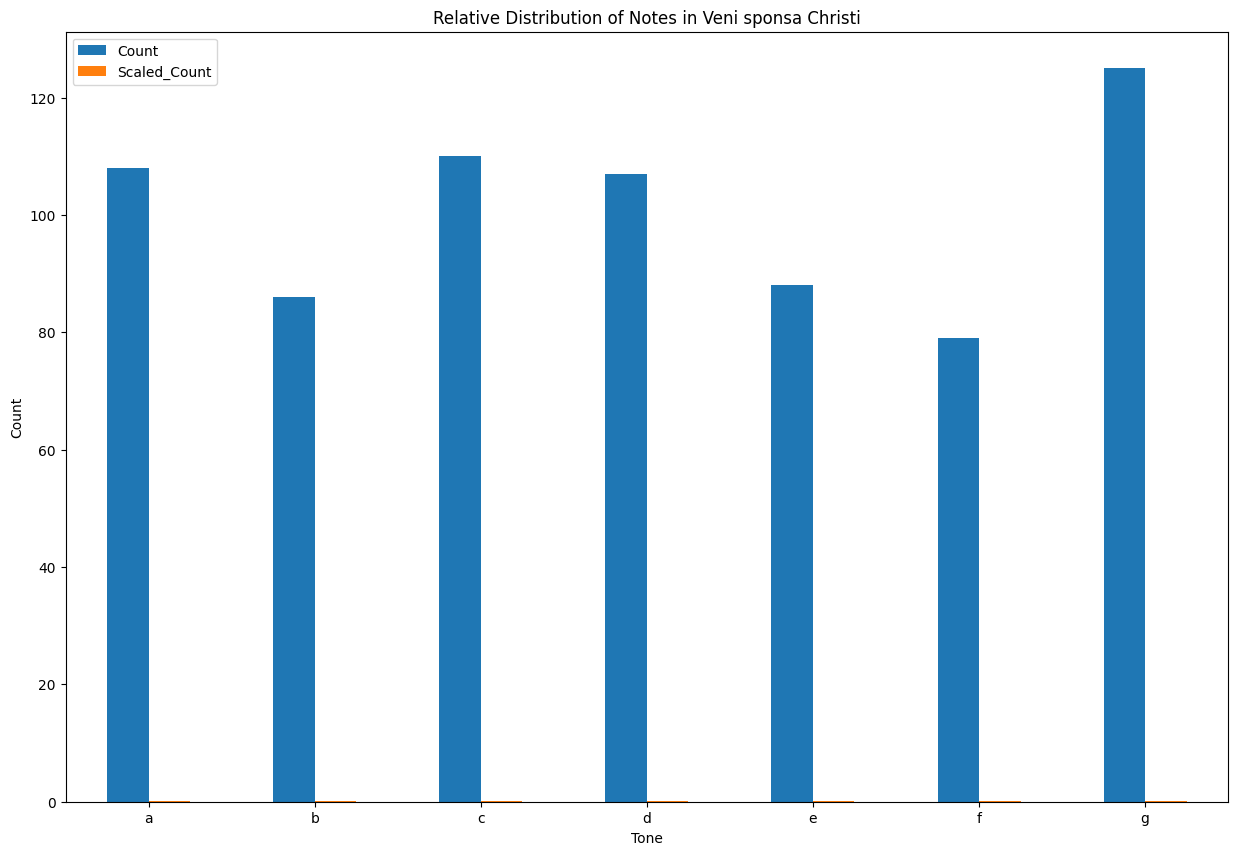

In [23]:
label = "Relative Distribution of Notes in " + soup.find('title').text.strip()
counted_notes.plot(kind="bar", figsize=(15, 10))
plt.title(label)
plt.xticks(rotation = 0)
plt.xlabel("Tone")
plt.ylabel("Count")
plt.show()

### A Radar Plot of Notes

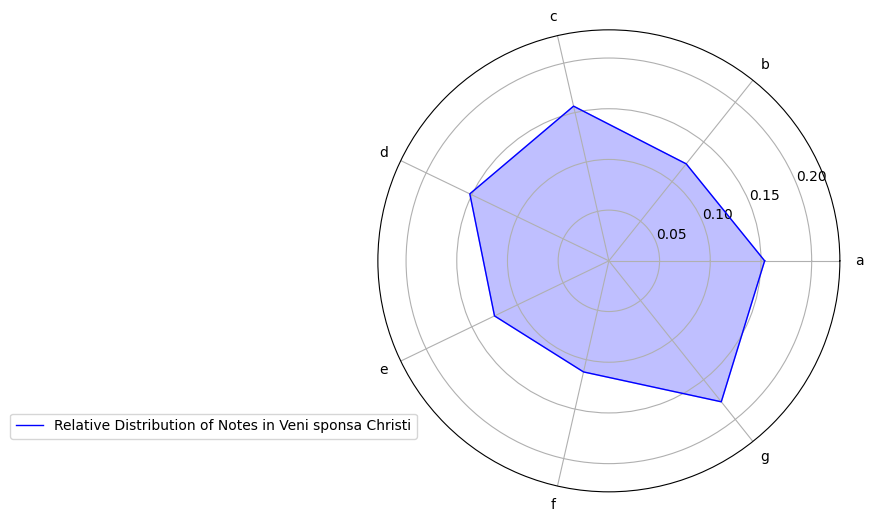

In [24]:
# Calculate the angles for each category
label = "Relative Distribution of Notes in " + soup.find('title').text.strip()
categories = list(counted_notes.index)
angles = [n / len(categories) * 2 * math.pi for n in range(len(categories))]
angles += angles[:1]

# Create the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, counted_notes['Scaled_Count'].tolist() + counted_notes['Scaled_Count'].tolist()[:1], linewidth=1, linestyle='solid', color='blue', label=label)
ax.fill(angles, counted_notes['Scaled_Count'].tolist() + counted_notes['Scaled_Count'].tolist()[:1], alpha=0.25, color='blue')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the y-axis limit
ax.set_ylim(0, max(counted_notes['Scaled_Count']) + 0.05)
# Add a legend
ax.legend(loc='lower right', bbox_to_anchor=(0.1, 0.1))
# Display the plot
plt.show()

### Bar Chart of Notes in Each Voice

#### A Student Experiment

In [25]:
# One Student Tried This:
#looking @ pitch distribution for each voice
def get_pitch_dist(n, soup): #takes a staff number, returns dataframe of pitch distribution
    staves = soup.find_all("staff", n = n) #all instances of the given staf
    staff_notes = []
    for staff in staves:
        notes = staff.find_all("note")  
        for note in notes:
            staff_notes.append(note.get("pname"))

    note_counts = pd.Series(Counter(staff_notes)).to_frame(n).sort_index()
    
    return note_counts

df = get_pitch_dist(1, soup)

for i in range(1, 4):
    df = pd.concat([df, get_pitch_dist(i+1, soup)], axis = 1)
df

1   2   3   4
a  40  29  17  22
b  31  19  21  15
c  30  17  38  25
d  28  23  42  14
e  14  31  31  12
f  11  33  18  17
g  24  53  22  26

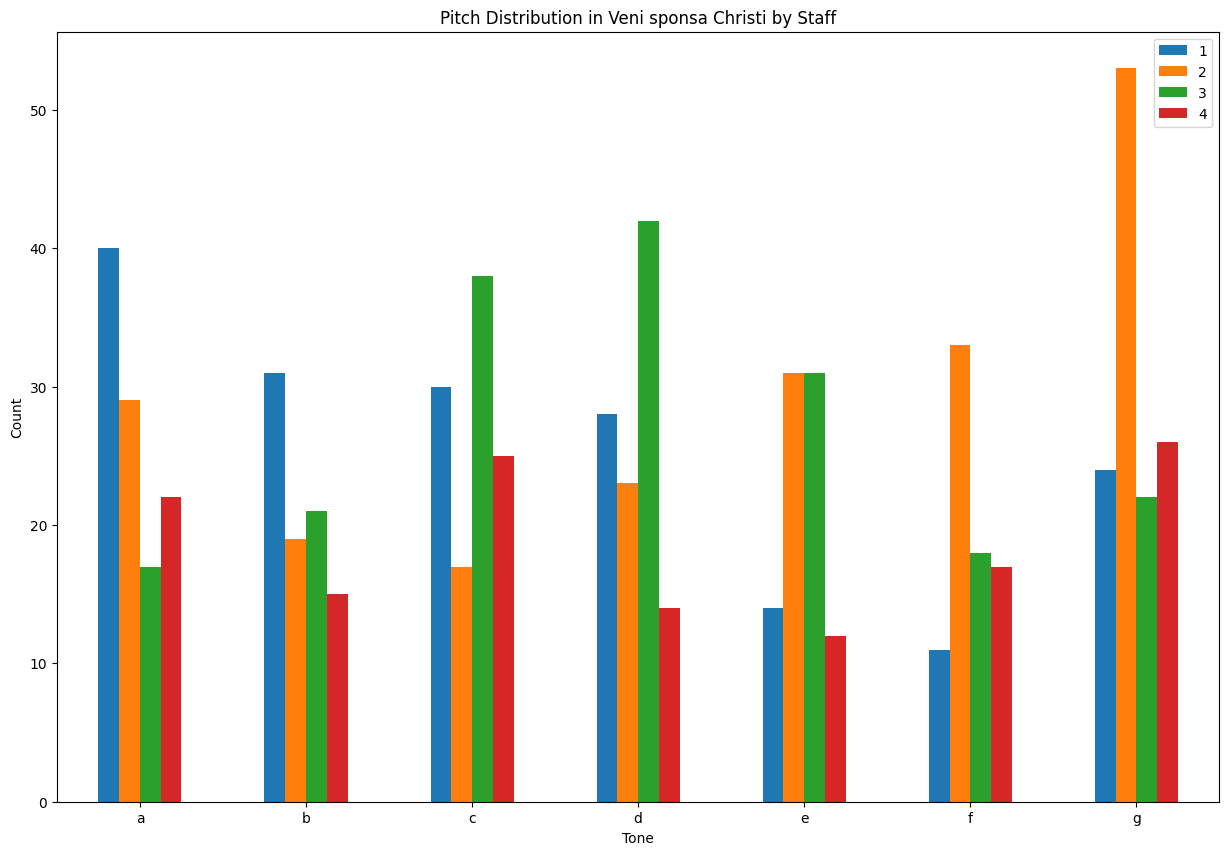

In [26]:
# Bar Chart of the Data From Above
df.plot(kind="bar", figsize=(15, 10))
plt.title("Pitch Distribution in" + ' ' + soup.title.text.strip() + " by Staff")
plt.xticks(rotation = 0)
plt.xlabel("Tone")
plt.ylabel("Count")
plt.show()

### Line Plot of Activity

#### A Student Experiment

In [27]:

measures = soup.find_all('measure')
list_note_counts = []
for measure in measures:
    for staff in measure.find_all('staff'):
        
        temp_dict = {'measure_id' :  measure.get('n'),
                     'staff_id' : staff.get('n'),
                    'note_count' : len(staff.find_all('note'))}
        list_note_counts.append(temp_dict)
note_counts = pd.DataFrame(list_note_counts)
note_counts


measure_id staff_id  note_count
0            1        1           1
1            1        2           0
2            1        3           0
3            1        4           0
4            2        1           2
..         ...      ...         ...
263         66        4           2
264         67        1           1
265         67        2           1
266         67        3           1
267         67        4           1

[268 rows x 3 columns]

In [28]:
# Create line chart
fig = go.Figure()
label = "Notes Per Measure Per Staff in " + soup.find('title').text.strip()

# Iterate over unique staff_id values
for staff_id in note_counts['staff_id'].unique():
    # Filter data for the specific staff_id
    filtered_df = note_counts[note_counts['staff_id'] == staff_id]
    
    # Add trace with the specific staff_id and color
    fig.add_trace(go.Scatter(x=filtered_df['measure_id'], y=filtered_df['note_count'], name=staff_id))

# Customize chart appearance
fig.update_layout(title=label,
                  xaxis_title='Measure ID',
                  yaxis_title='Note Count')

# Show the chart
fig.show()

### Plotting Durational Differences and Activity in Voices

#### A Student Experiment

In [29]:
# Credit to Keith Mburu (HC '23)
measures = soup.find_all("measure")

def calculate_durations():
    for measure in measures:
        voices = measure.find_all('staff')

        voices_notes = []
        for voice in voices:
            voices_notes.append(voice.find_all('note'))

        for voice_name, voice_notes in zip(voice_names, voices_notes):
            measure_dur = 0
            for note in voice_notes:
                base_dur = note_lengths[note.get('dur')]
                measure_dur += base_dur
                # account for dotted notes
                if note.get('dots'):
                    for i in range(int(note.get('dots'))):
                        base_dur *= 0.5
                        measure_dur += base_dur
            # measure-wise update
            durations[voice_name][0].append(measure_dur)
            # cumulative update
            if durations[voice_name][1]:
                durations[voice_name][1].append(durations[voice_name][1][-1] + measure_dur)
            else:
                durations[voice_name][1].append(measure_dur)
    return durations

note_lengths = {'4': 0.5, '2': 1, '1': 2, 'breve': 4, 'long': 8, '8' : 8}
voice_names = ['Cantus', 'Altus', 'Tenor', 'Bassus']
durations = {v: [[], []] for v in voice_names}

def measure_wise_plot(durations):
    fig = go.Figure()
    for voice_name in voice_names:
        fig.add_trace(go.Scatter(x=list(range(1, len(measures)+1)), 
                                 y=durations[voice_name][0], 
                                 mode='lines', 
                                 name=voice_name))
    fig.update_layout(title='Activity in each voice at each measure',
                      xaxis_title='Measure number',
                      yaxis_title='Duration in measure')
    fig.show()
    
def cumulative_plot(durations):
    fig = go.Figure()
    for voice_name in voice_names:
        fig.add_trace(go.Scatter(x=list(range(1, len(measures)+1)), 
                                 y=durations[voice_name][1], 
                                 mode='lines', 
                                 name=voice_name))
    fig.update_layout(title='Cumulative activity for each voice at each measure',
                      xaxis_title='Measure number',
                      yaxis_title='Cumulative Duration')
    fig.show()
    
    
durations = calculate_durations()
measure_wise_plot(durations)
cumulative_plot(durations)

# Looking at Editorial Habits
### Notes with Accidentals (Supplied and Otherwise)

In [30]:
# explain how the following code finds the last note of the first staff of measure 66
m_66_last_note = soup.find('measure', {'n' : '66'}).findChild('staff', {'n': '1'}).find_all('note')[-1]
print(m_66_last_note.prettify())

<note dur="2" dur.ppq="512" oct="4" pname="f" pnum="66" stem.dir="up" xml:id="m-2188">
 <supplied reason="edit" xml:id="m-469e72a0-f1e2-4792-8290-bafbac06fb3f">
  <accid accid="s" func="edit" place="above" xml:id="m-2189"/>
 </supplied>
</note>



In [31]:
# note that the <accid> tag is a child of the note, so we must find it before accessing the value of the accid attribute
m_66_last_note.find('accid').get('accid')

's'

## Supplied Elements

In [32]:
# how many supplied?
len(soup.find_all("supplied"))

9

### More detail about the supplied elements: What kind of accidental?  Which measures? Which editor?

#### See below for an explantion of how we find the `<editor>`  tag.


In [33]:
list_supplied_accid_data = []

for supplied in soup.find_all("supplied"):
    accidentals = supplied.find_all('accid')
    for accidental in accidentals:
        
        temp_dict = {
                     'title' : soup.find('title').text.strip(),
                     'composer' : soup.find('persName', {'role' : 'composer'}).text.strip(),
                     'editor' : soup.find('persName', {'role' : 'editor'}).text.strip(),
                     'parent_measure_number' : accidental.find_parent('measure').get('n'),
                     'pitch' : accidental.find_parent('note').get('pname'),
                     'accid_value' : accidental.get('accid')
        }
        
        # append each dictionary to a list of all the results
        list_supplied_accid_data.append(temp_dict)
        
supplied_accids = pd.DataFrame(list_supplied_accid_data)
supplied_accids["parent_measure_number"] = supplied_accids["parent_measure_number"].apply(int)
supplied_accids

title                          composer          editor  \
0  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
1  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
2  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
3  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
4  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
5  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
6  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
7  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   
8  Veni sponsa Christi  Giovanni Pierluigi da Palestrina  Marco Gurrieri   

   parent_measure_number pitch accid_value  
0                      6     f           s  
1                      6     f           s  
2                     11     f           s  
3                     17     f           s  
4                     19     f           s  
5                     41     g           s  
6                     43     g           s  
7                     45     c           s  
8                     66     f           s

### Grouping the Results by Measure

In [34]:
grouped_df = supplied_accids.groupby('parent_measure_number').agg({'pitch': 'count', 'accid_value': 'count'}).reset_index()
grouped_df = grouped_df.sort_values('parent_measure_number')
grouped_df

parent_measure_number  pitch  accid_value
0                      6      2            2
1                     11      1            1
2                     17      1            1
3                     19      1            1
4                     41      1            1
5                     43      1            1
6                     45      1            1
7                     66      1            1

### Plot the Supplied Accidentals Over Time

In [35]:

measAll = soup.findAll("measure")

supplied_dict = {}

for measure in measAll:
    if len(measure.find_all('supplied')) > 0:
        meas_no = int(measure.get("n"))
        supplieds = measure.find_all('supplied')
        counter = 0
        for supplied in supplieds:
            if supplied.find_all(attrs={'accid': True}):
                counter += 1
            supplied_dict.update({meas_no:counter})
            
accids = pd.DataFrame(supplied_dict.items(), columns=['Measure', 'Count'])

fig = go.Figure()

fig.add_trace(go.Scatter(x=accids['Measure'], y=accids['Count'], name=staff_id))

# Customize chart appearance
fig.update_layout(title=label,
                  xaxis_title='Measure',
                  yaxis_title='Count')

# Show the chart
fig.show()

## Find Editors

In [36]:
# title statement
print(soup.titleStmt.prettify())

<titleStmt>
 <title>
  Veni sponsa Christi
 </title>
 <respStmt>
  <persName auth="VIAF" auth.uri="http://viaf.org/viaf/92280854" role="composer">
   Giovanni Pierluigi da Palestrina
  </persName>
  <persName role="editor">
   Marco Gurrieri
  </persName>
  <persName role="editor">
   Vincent Besson
  </persName>
  <persName role="editor">
   Richard Freedman
  </persName>
 </respStmt>
</titleStmt>



In [37]:
editors = soup.titleStmt.find_all('persName', {'role' : 'editor'})

for editor in editors:
    print(editor.prettify())

<persName role="editor">
 Marco Gurrieri
</persName>

<persName role="editor">
 Vincent Besson
</persName>

<persName role="editor">
 Richard Freedman
</persName>


## Working with a Corpus of Pieces

In [38]:
# Define a Corpus
corpus_list = ['https://crimproject.org/mei/CRIM_Model_0019.mei',
               'https://crimproject.org/mei/CRIM_Model_0025.mei',
               'https://crimproject.org/mei/CRIM_Model_0029.mei',
               'https://crimproject.org/mei/CRIM_Model_0031.mei',
               'https://crimproject.org/mei/CRIM_Model_0036.mei',
               'https://crimproject.org/mei/CRIM_Model_0046.mei',
               'https://crimproject.org/mei/CRIM_Model_0047.mei']

In [39]:
def calculate_ficta_factors(corpus_list):
    list_piece_data = []
    list_ficta_factors = []

    # get each piece as BS object
    for piece in corpus_list:
        print(piece)
        xml_document = getXML(piece)
        soup = BeautifulSoup(xml_document, 'xml')
        # find all the accidentals that are editorial
        # divide the number of such editorial accidentals by the total number of notes in the piece ('ficta factor')
        ficta_factor = len(soup.find_all('accid', {'func' : 'edit'})) / len(soup.find_all('note'))
        # round those ratios to no more than three decimal points
        list_ficta_factors.append(round(ficta_factor, 3))
        # build a temporary dictionary of the data, with file_name, editor, composer, and the ficta factors
        temp_dict = {'file_name' : os.path.basename(piece),
                     'composer' : soup.find('persName', {'role' : 'composer'}).text.strip(),
                     'editor' : soup.find('persName', {'role' : 'editor'}).text.strip(),
                     'ficta_factor' : ficta_factor}
        # append each dictionary to a list of all the results
        list_piece_data.append(temp_dict)

    # make a dataframe out of that list of results
    df = pd.DataFrame(list_piece_data)
    # create 'bins' of any number, based on the ranges of the ficta factors
    df['ficta_bins'] = pd.cut(df['ficta_factor'], bins=3, labels=['low', 'medium', 'high'])
    return df

In [40]:
df = calculate_ficta_factors(corpus_list)

https://crimproject.org/mei/CRIM_Model_0019.mei
https://crimproject.org/mei/CRIM_Model_0025.mei
https://crimproject.org/mei/CRIM_Model_0029.mei
https://crimproject.org/mei/CRIM_Model_0031.mei
https://crimproject.org/mei/CRIM_Model_0036.mei
https://crimproject.org/mei/CRIM_Model_0046.mei
https://crimproject.org/mei/CRIM_Model_0047.mei


In [41]:
df

file_name                          composer  \
0  CRIM_Model_0019.mei  Giovanni Pierluigi da Palestrina   
1  CRIM_Model_0025.mei                  Cipriano de Rore   
2  CRIM_Model_0029.mei                   Nicolas Gombert   
3  CRIM_Model_0031.mei                    Lupus Hellinck   
4  CRIM_Model_0036.mei               Tomás Luis Victoria   
5  CRIM_Model_0046.mei                  Cipriano de Rore   
6  CRIM_Model_0047.mei                     Jean Lhertier   

                         editor  ficta_factor ficta_bins  
0                Marco Gurrieri      0.012802        low  
1               Maxime Popineau      0.002353        low  
2  María Elena Cuenca Rodriguez      0.038835       high  
3                   David Fiala      0.008758        low  
4                  Brian Marble      0.004323        low  
5               Pyrros Bachimas      0.017839     medium  
6                 Yoav Belinsky      0.003303        low

### Grouping By Composer and Editor

Here we work with data for _all_ the CRIM files.  The analysis can take some time to run, so we have done this in advance and saved the results locally as CSV files.  We import those to use in the visualizations here:

`df_all = pd.read_csv("Files_For_BS_MEI_Notebook/2023-08-29_ficta_all.csv")`

In [42]:
df_all = pd.read_csv("Files_For_BS_MEI_Notebook/2023-08-29_ficta_all.csv")


In [43]:
df_all.groupby(["composer", "editor"]).ficta_factor.mean()


composer                 editor         
Adrian Willaert          Vincent Besson     0.014295
Annibale Padovano        Pyrros Bachimas    0.012638
Anonymous                Marco Gurrieri     0.000000
Antoine de Févin         Vincent Besson     0.018235
Attr. Balbulus Notker    Vincent Besson     0.000000
                                              ...   
Roland de Lassus         Vincent Besson     0.014186
Thomas Champion          David Fiala        0.007018
Tomás Luis Victoria      Brian Marble       0.004323
Tomás Luis de Victoria   Brian Marble       0.004775
Tom√°s Luis de Victoria  Brian Marble       0.007405
Name: ficta_factor, Length: 64, dtype: float64

### Reviewing Editors and Composers

Notice that this can help us see some inconsistencies in the data.

In [44]:
sorted(df_all.editor.unique())

['Andrea Puentes',
 'Andrea Puentes-Blanco',
 'Brian Marble',
 'Brian Russell',
 'Christina Cassia',
 'David Fiala',
 'Franz Körndle',
 'Jessie Ann Owens',
 'Kévin Roger',
 'Marco Gurrieri',
 'Marie Breillat',
 'María Elena Cuenca Rodriguez',
 'María Elena Cuenca Rodríguez',
 'Maxime Popineau',
 'Michael Winter',
 'Pothárn Imre',
 'Pyrros Bachimas',
 'Sabine Cassola',
 'Vincent Besson',
 'Yoav Belinsky']

In [45]:
sorted(df_all.composer.unique())

['Adrian Willaert',
 'Annibale Padovano',
 'Anonymous',
 'Antoine de Févin',
 'Attr. Balbulus Notker',
 'Cipriano de Rore',
 'Claudin de Sermisy',
 'Claudio Merulo',
 'Cristóbal de Morales',
 'Didier Lupi',
 'Domenico Ferrabosco',
 'Dominique Phinot',
 'Francisco Guerrero',
 'Giovanni Pierluigi da Palestrina',
 'Guillaume Le Heurteur',
 'Ippolito Baccusi',
 'Jachet de Mantua',
 'Jacob Clemens non Papa',
 'Jean Courtois',
 'Jean Guyon',
 'Jean Hérissant',
 'Jean Lhertier',
 'Jean Mouton',
 'Johannes Lupi',
 'Josquin Des Prés',
 'Leonhard Lechner',
 'Loyset Pieton',
 'Lupus Hellinck',
 'Mathieu Sohier',
 'Mathurin Forestier',
 'Nicolas De Marle',
 'Nicolas Gombert',
 'Nicole des Celliers de Hesdin',
 'Pere Riquet',
 'Philippe Verdelot',
 'Pierre Cadéac',
 'Pierre Clereau',
 'Pierre Colin',
 'Pierre Daulphin',
 'Pierre Passereau',
 'Pierre Sandrin',
 'Pierre de Manchicourt',
 'Roland de  Lassus',
 'Roland de Lassus',
 'Thomas Champion',
 'Tomás Luis Victoria',
 'Tomás Luis de Victoria',
 

### Charts of Editor, Composer, and Ficta Information

<AxesSubplot: ylabel='editor'>

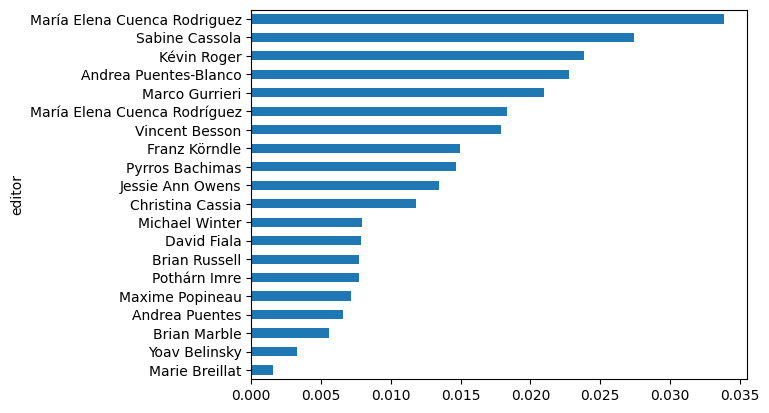

In [46]:
df_all.groupby(["editor"]).ficta_factor.mean().sort_values(ascending=True).plot(kind="barh")


In [47]:
editor_stats = df_all.groupby('editor').agg({
    'ficta_factor': 'mean',
    'file_name': 'count'
}).rename(columns={'ficta_factor': 'avg_ficta_factor', 'file_name': 'num_pieces'})

editor_stats = editor_stats.sort_values(by='avg_ficta_factor', ascending=False)
editor_stats.head()

avg_ficta_factor  num_pieces
editor                                                    
María Elena Cuenca Rodriguez          0.033857           3
Sabine Cassola                        0.027427           1
Kévin Roger                           0.023860          15
Andrea Puentes-Blanco                 0.022804           5
Marco Gurrieri                        0.020948          19

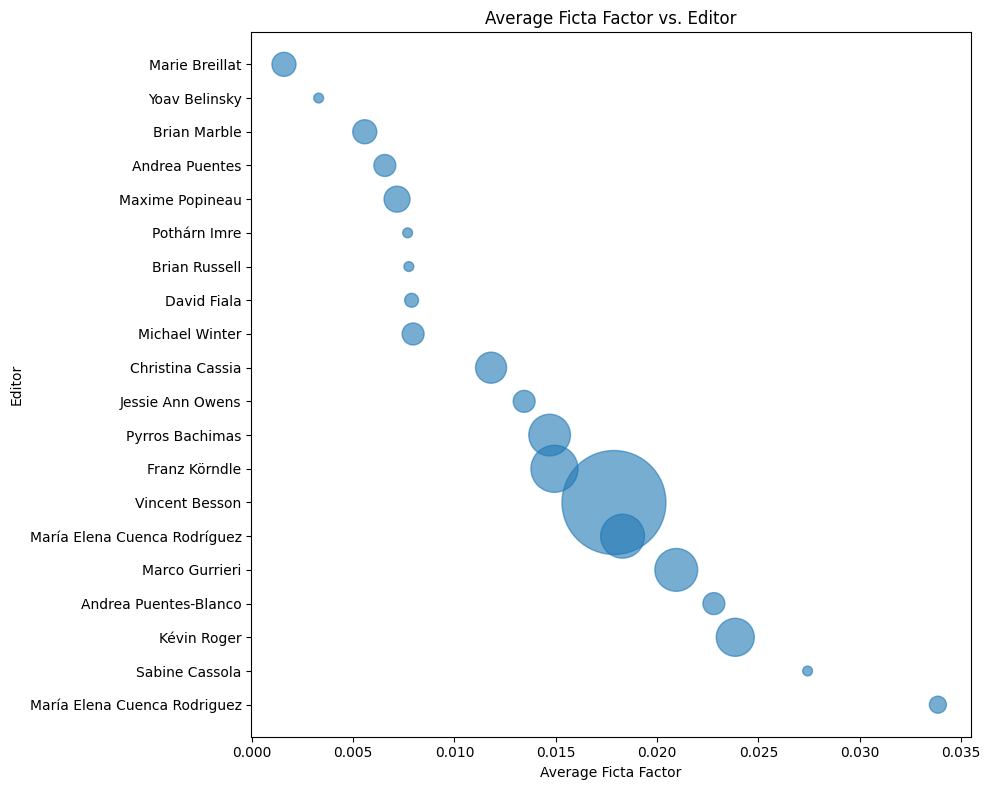

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))


sc = ax.scatter(editor_stats.avg_ficta_factor, editor_stats.index, s=editor_stats.num_pieces*50, alpha=0.6)

ax.set_title('Average Ficta Factor vs. Editor')
ax.set_ylabel('Editor')
ax.set_xlabel('Average Ficta Factor')

plt.tight_layout()
plt.show()
fig.savefig("2023-08-29_editor_bubbles.pdf")

In [49]:
editor_stats


avg_ficta_factor  num_pieces
editor                                                    
María Elena Cuenca Rodriguez          0.033857           3
Sabine Cassola                        0.027427           1
Kévin Roger                           0.023860          15
Andrea Puentes-Blanco                 0.022804           5
Marco Gurrieri                        0.020948          19
María Elena Cuenca Rodríguez          0.018297          20
Vincent Besson                        0.017874         112
Franz Körndle                         0.014938          23
Pyrros Bachimas                       0.014698          18
Jessie Ann Owens                      0.013442           5
Christina Cassia                      0.011810          10
Michael Winter                        0.007963           5
David Fiala                           0.007888           2
Brian Russell                         0.007752           1
Pothárn Imre                          0.007692           1
Maxime Popineau                       0.007170           7
Andrea Puentes                        0.006568           5
Brian Marble                          0.005576           6
Yoav Belinsky                         0.003303           1
Marie Breillat                        0.001590           6

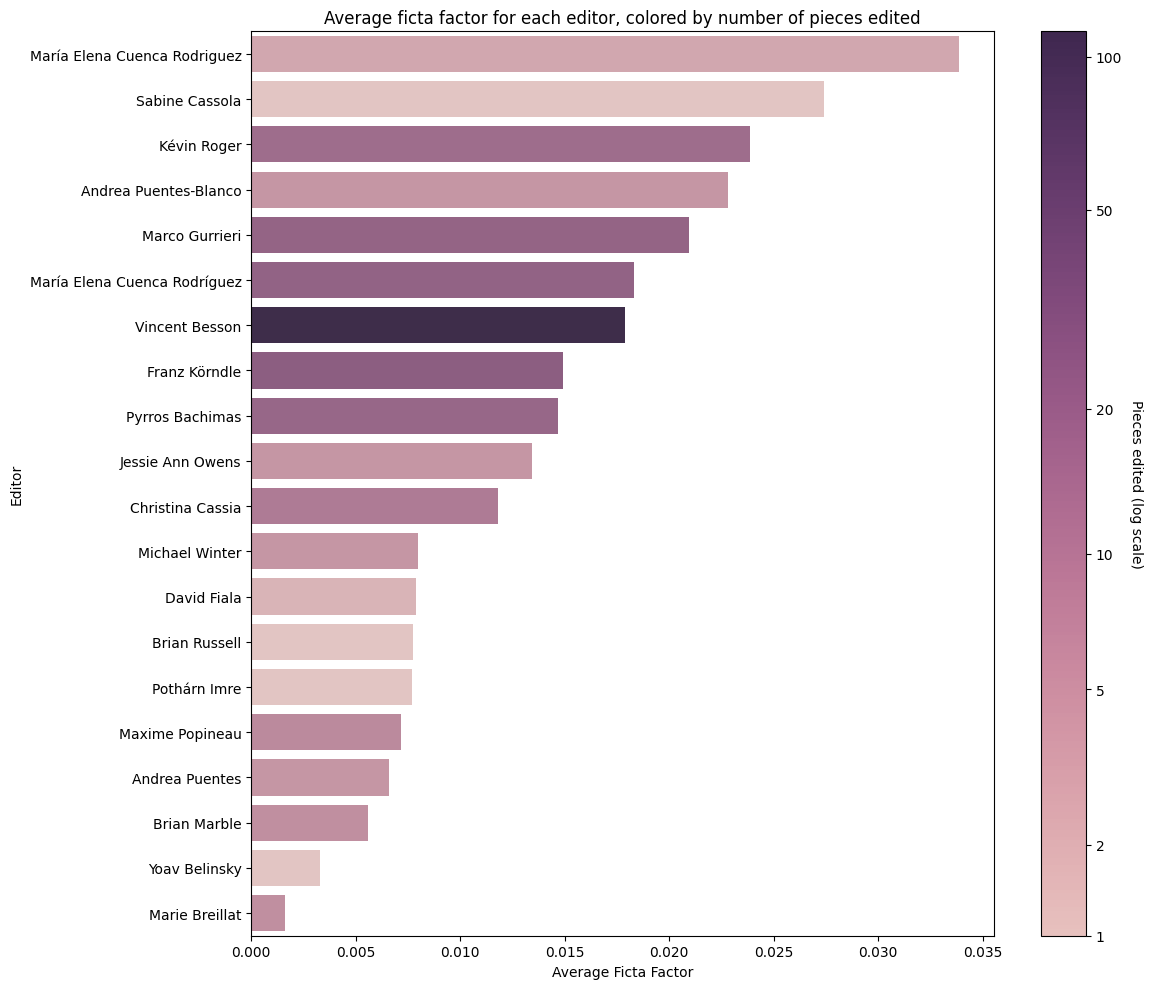

In [50]:
palette = sns.cubehelix_palette(light=0.8, dark=0.2, as_cmap=True)


log_norm = plt.Normalize(np.log1p(editor_stats['num_pieces'].min()), np.log1p(editor_stats['num_pieces'].max()))
log_colors = palette(log_norm(np.log1p(editor_stats['num_pieces'])))


fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=editor_stats['avg_ficta_factor'], y=editor_stats.index, palette=log_colors, dodge=False, ax=ax)


cbar = plt.colorbar(plt.cm.ScalarMappable(norm=log_norm, cmap=palette), ax=ax)
cbar.set_label('Pieces edited (log scale)', rotation=270, labelpad=15)
cbar.set_ticks(np.log1p([1, 2, 5, 10, 20, 50, 100]))
cbar.set_ticklabels([1, 2, 5, 10, 20, 50, 100])

ax.set_xlabel('Average Ficta Factor')
ax.set_ylabel('Editor')
ax.set_title('Average ficta factor for each editor, colored by number of pieces edited')
plt.tight_layout()
plt.show()
fig.savefig("2023-08-29_editor_bar.pdf")

### Another Chart to Compare Editors and Pieces, with Colors for Ficta Factor

<AxesSubplot: xlabel='composer', ylabel='editor'>

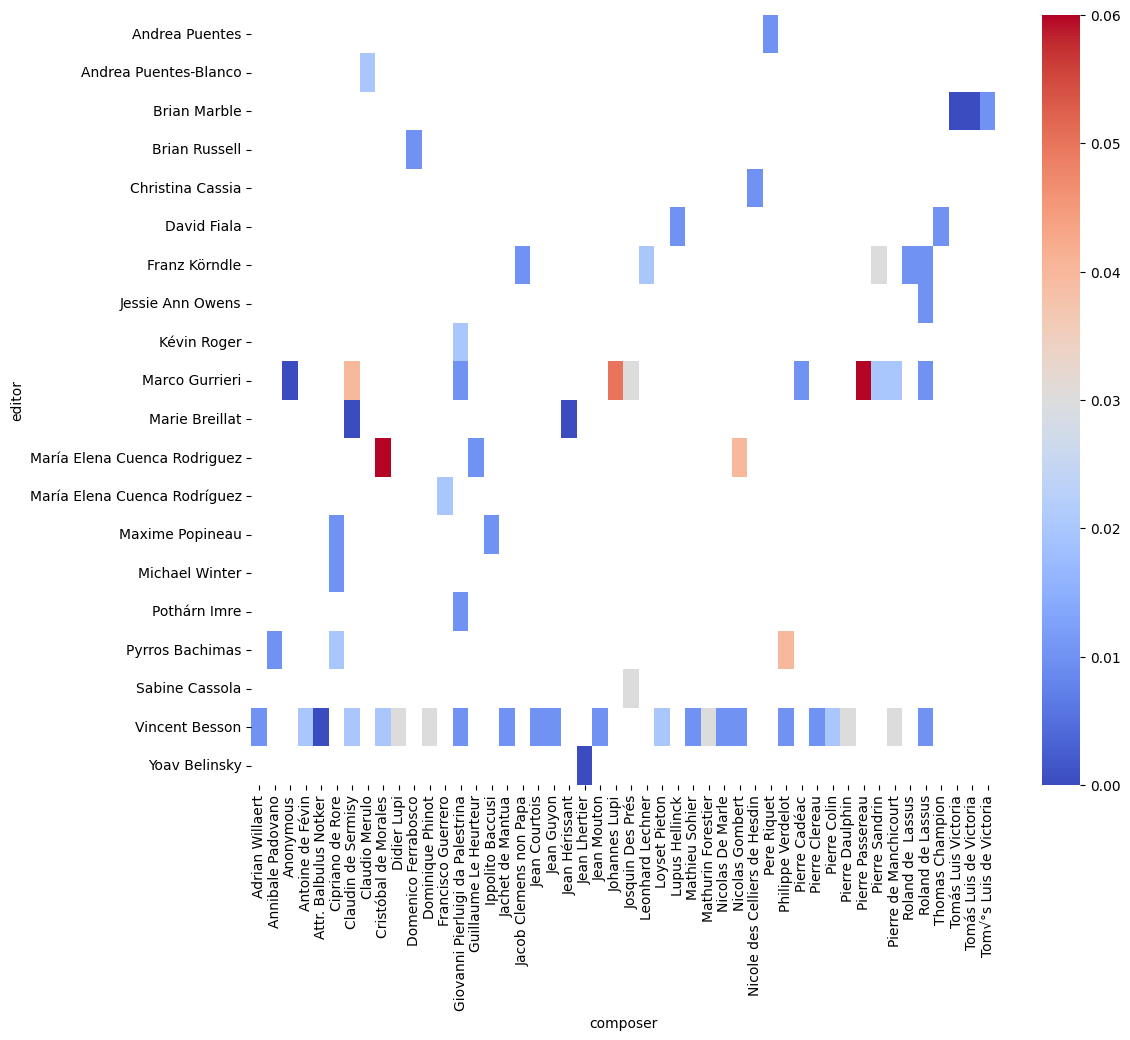

In [51]:
composer_editor_matrix = df_all.pivot_table(
    values="ficta_factor", 
    index="editor", 
    columns="composer", 
    aggfunc="mean"
).round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(composer_editor_matrix, annot=False, cmap="coolwarm")

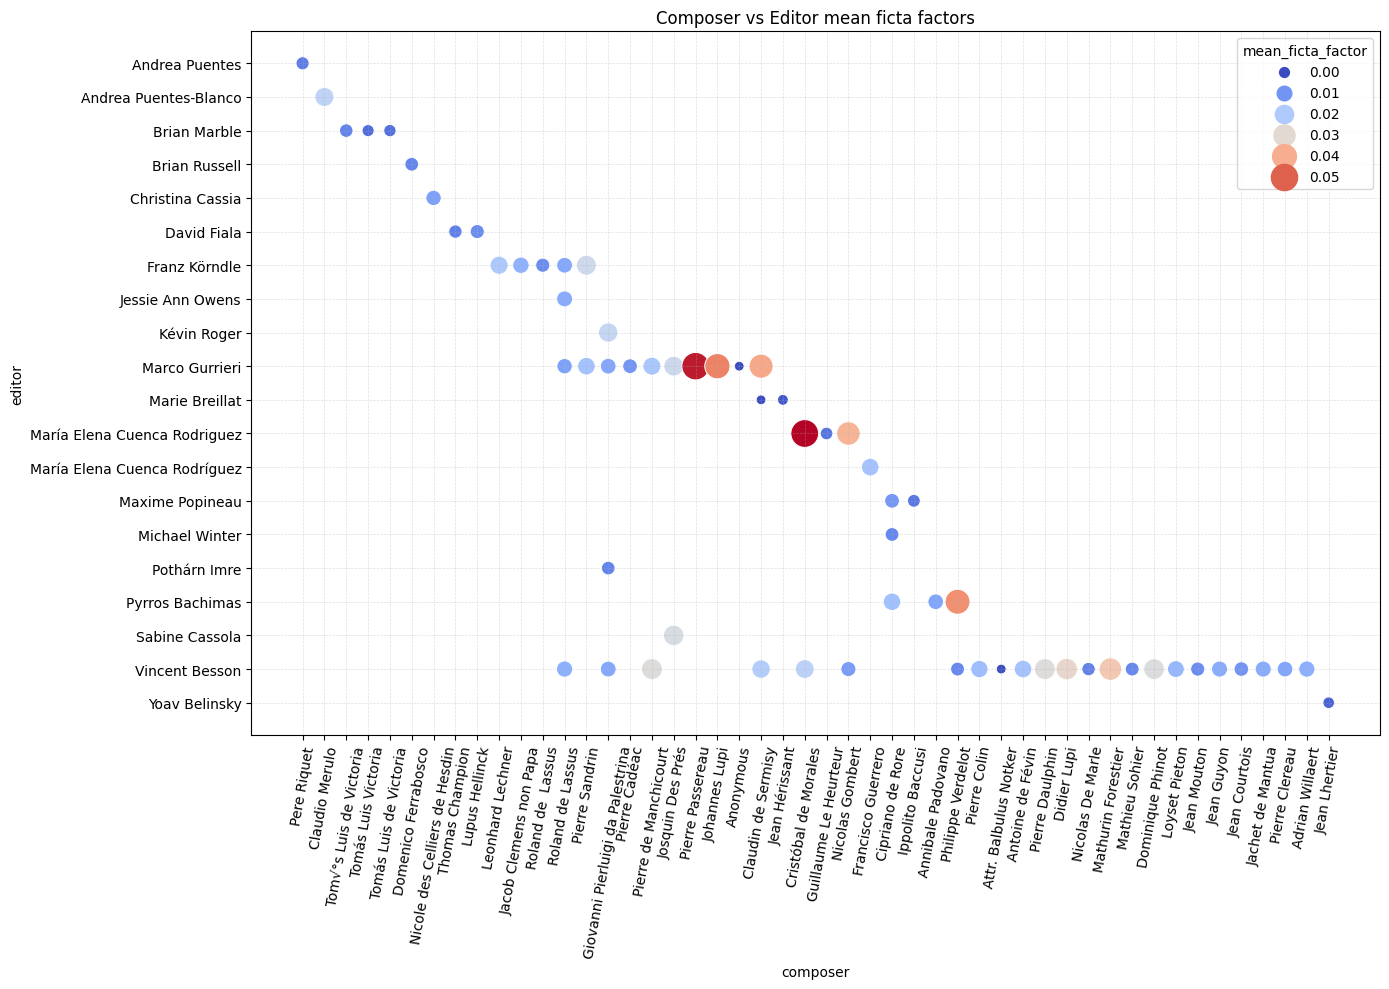

In [52]:
agg_data = (
    df_all.groupby(['composer', 'editor'])
        .agg(mean_ficta_factor=('ficta_factor', 'mean'))
        .reset_index()
        .sort_values(by='editor')
)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=agg_data, 
        x='composer', 
        y='editor', 
        hue='mean_ficta_factor', 
        palette="coolwarm", 
        size='mean_ficta_factor', sizes=(50, 400)
)

plt.xticks(rotation=80)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)

plt.title('Composer vs Editor mean ficta factors')
plt.tight_layout()
# option to save PDF version
# plt.savefig("2023-08-30_editor_composer_ficta_factor.pdf")
plt.show()

### Networks of Editors and Pieces

In [53]:
composer_nodes_and_degrees = agg_data.groupby("composer").size().to_dict()
editor_nodes_and_degrees = agg_data.groupby("editor").size().to_dict()
editor_nodes_and_degrees

{'Andrea Puentes': 1,
 'Andrea Puentes-Blanco': 1,
 'Brian Marble': 3,
 'Brian Russell': 1,
 'Christina Cassia': 1,
 'David Fiala': 2,
 'Franz Körndle': 5,
 'Jessie Ann Owens': 1,
 'Kévin Roger': 1,
 'Marco Gurrieri': 10,
 'Marie Breillat': 2,
 'María Elena Cuenca Rodriguez': 3,
 'María Elena Cuenca Rodríguez': 1,
 'Maxime Popineau': 2,
 'Michael Winter': 1,
 'Pothárn Imre': 1,
 'Pyrros Bachimas': 3,
 'Sabine Cassola': 1,
 'Vincent Besson': 23,
 'Yoav Belinsky': 1}

In [54]:
list(agg_data.itertuples())
G = nx.DiGraph()

for c, s in composer_nodes_and_degrees.items():
    G.add_node(c, size=20, group=0, node_type="composer")
    
    
for e, s in editor_nodes_and_degrees.items():
    G.add_node(e, size=20, group=1, node_type="editor")
    
    
for row in agg_data.itertuples():
    G.add_edge(row.editor, 
               row.composer, 
               value=row.mean_ficta_factor, 
               label=round(row.mean_ficta_factor, 4))

In [55]:
display_network(G, filename="composer_editor_ficta_network2.html")

### Full CRIM Corpus

In [56]:
all_pieces = [
 'https://crimproject.org/mei/CRIM_Mass_0001_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0001_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0001_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0001_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0001_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0002_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0002_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0002_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0002_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0002_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0003_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0003_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0003_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0003_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0003_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0004_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0004_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0004_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0004_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0004_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0005_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0005_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0005_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0005_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0005_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0006_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0006_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0006_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0006_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0006_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0007_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0007_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0007_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0007_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0007_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0008_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0008_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0008_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0008_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0008_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0009_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0009_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0009_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0009_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0009_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0010_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0010_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0010_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0010_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0010_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0011_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0011_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0011_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0011_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0011_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0012_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0012_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0012_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0012_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0012_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0013_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0013_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0013_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0013_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0013_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0014_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0014_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0014_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0014_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0014_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0015_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0015_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0015_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0015_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0015_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0016_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0016_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0016_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0016_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0016_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0017_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0017_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0017_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0017_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0017_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0018_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0018_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0018_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0018_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0018_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0019_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0019_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0019_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0019_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0019_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0020_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0020_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0020_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0020_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0020_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0021_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0021_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0021_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0021_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0021_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0023_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0023_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0023_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0023_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0023_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0024_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0024_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0024_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0024_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0024_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0025_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0025_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0025_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0025_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0025_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0026_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0026_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0026_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0026_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0026_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0027_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0027_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0027_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0027_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0027_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0028_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0028_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0028_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0028_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0028_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0029_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0029_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0029_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0029_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0029_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0030_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0030_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0030_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0030_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0030_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0031_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0031_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0031_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0031_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0031_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0032_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0032_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0032_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0032_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0032_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0033_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0033_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0033_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0033_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0033_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0036_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0036_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0036_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0036_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0036_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0038_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0038_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0038_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0038_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0038_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0039_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0039_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0039_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0039_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0039_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0042_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0042_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0042_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0042_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0042_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0043_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0043_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0043_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0043_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0043_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0044_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0044_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0044_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0044_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0044_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0045_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0045_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0045_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0045_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0045_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0046_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0046_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0046_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0046_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0046_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0047_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0047_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0047_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0047_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0047_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0048_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0048_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0048_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0048_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0048_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0049_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0049_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0049_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0049_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0049_5.mei',
 'https://crimproject.org/mei/CRIM_Mass_0050_1.mei',
 'https://crimproject.org/mei/CRIM_Mass_0050_2.mei',
 'https://crimproject.org/mei/CRIM_Mass_0050_3.mei',
 'https://crimproject.org/mei/CRIM_Mass_0050_4.mei',
 'https://crimproject.org/mei/CRIM_Mass_0050_5.mei',
 'https://crimproject.org/mei/CRIM_Model_0001.mei',
 'https://crimproject.org/mei/CRIM_Model_0002.mei',
 'https://crimproject.org/mei/CRIM_Model_0003.mei',
 'https://crimproject.org/mei/CRIM_Model_0004.mei',
 'https://crimproject.org/mei/CRIM_Model_0005.mei',
 'https://crimproject.org/mei/CRIM_Model_0006.mei',
 'https://crimproject.org/mei/CRIM_Model_0007.mei',
 'https://crimproject.org/mei/CRIM_Model_0008.mei',
 'https://crimproject.org/mei/CRIM_Model_0009.mei',
 'https://crimproject.org/mei/CRIM_Model_0010.mei',
 'https://crimproject.org/mei/CRIM_Model_0011.mei',
 'https://crimproject.org/mei/CRIM_Model_0012.mei',
 'https://crimproject.org/mei/CRIM_Model_0013.mei',
 'https://crimproject.org/mei/CRIM_Model_0014.mei',
 'https://crimproject.org/mei/CRIM_Model_0015.mei',
 'https://crimproject.org/mei/CRIM_Model_0016.mei',
 'https://crimproject.org/mei/CRIM_Model_0017.mei',
 'https://crimproject.org/mei/CRIM_Model_0018.mei',
 'https://crimproject.org/mei/CRIM_Model_0019.mei',
 'https://crimproject.org/mei/CRIM_Model_0020.mei',
 'https://crimproject.org/mei/CRIM_Model_0021.mei',
 'https://crimproject.org/mei/CRIM_Model_0022.mei',
 'https://crimproject.org/mei/CRIM_Model_0023.mei',
 'https://crimproject.org/mei/CRIM_Model_0024.mei',
 'https://crimproject.org/mei/CRIM_Model_0025.mei',
 'https://crimproject.org/mei/CRIM_Model_0026.mei',
 'https://crimproject.org/mei/CRIM_Model_0027.mei',
 'https://crimproject.org/mei/CRIM_Model_0029.mei',
 'https://crimproject.org/mei/CRIM_Model_0030.mei',
 'https://crimproject.org/mei/CRIM_Model_0031.mei',
 'https://crimproject.org/mei/CRIM_Model_0032.mei',
 'https://crimproject.org/mei/CRIM_Model_0033.mei',
 'https://crimproject.org/mei/CRIM_Model_0036.mei',
 'https://crimproject.org/mei/CRIM_Model_0037.mei',
 'https://crimproject.org/mei/CRIM_Model_0038.mei',
 'https://crimproject.org/mei/CRIM_Model_0039.mei',
 'https://crimproject.org/mei/CRIM_Model_0040.mei',
 'https://crimproject.org/mei/CRIM_Model_0041.mei',
 'https://crimproject.org/mei/CRIM_Model_0043.mei',
 'https://crimproject.org/mei/CRIM_Model_0045.mei',
 'https://crimproject.org/mei/CRIM_Model_0046.mei',
 'https://crimproject.org/mei/CRIM_Model_0047.mei',
 'https://crimproject.org/mei/CRIM_Model_0048.mei',
 'https://crimproject.org/mei/CRIM_Model_0049.mei',
 'https://crimproject.org/mei/CRIM_Model_0050.mei'
]

In [57]:
# Fun the ficta factor function on all files.  This will be SLOW!
# df_all = calculate_ficta_factors(all_pieces)